In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 15.4 MB/s 
     |████████████████████████████████| 3.5 MB 16.6 MB/s 


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
from termcolor import colored
from torch._C import dtype
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
Explainability_name = 'GNNExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [17]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [18]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [19]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [20]:
def split_dataset(dataset):
    indices = []
    train_percent = 0.7

    num_classes = dataset.num_classes
    
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)
    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)

    #print(len(train_index.tolist()), len(rest_index.tolist()))

    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index, size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset
    #return train_index, rest_index

In [24]:
One_Graph_dataset = split_dataset(dataset)
dataset_GNNE = One_Graph_dataset[0]
print(dataset_GNNE)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# **MLP MODEL**

In [25]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model_MLP = MLP(hidden_channels=16)
print(model_MLP)


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [26]:
model_MLP = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(dataset_GNNE.x)  # Perform a single forward pass.
      loss = criterion(out[dataset_GNNE.train_mask], dataset_GNNE.y[dataset_GNNE.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model_MLP.eval()
      out = model_MLP(dataset_GNNE.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset_GNNE.test_mask] == dataset_GNNE.y[dataset_GNNE.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 2.0306
Epoch: 002, Loss: 2.0188
Epoch: 003, Loss: 2.0068
Epoch: 004, Loss: 1.9935
Epoch: 005, Loss: 1.9795
Epoch: 006, Loss: 1.9645
Epoch: 007, Loss: 1.9487
Epoch: 008, Loss: 1.9332
Epoch: 009, Loss: 1.9205
Epoch: 010, Loss: 1.9019
Epoch: 011, Loss: 1.8887
Epoch: 012, Loss: 1.8717
Epoch: 013, Loss: 1.8533
Epoch: 014, Loss: 1.8412
Epoch: 015, Loss: 1.8273
Epoch: 016, Loss: 1.8077
Epoch: 017, Loss: 1.7974
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7820
Epoch: 020, Loss: 1.7730
Epoch: 021, Loss: 1.7577
Epoch: 022, Loss: 1.7513
Epoch: 023, Loss: 1.7508
Epoch: 024, Loss: 1.7417
Epoch: 025, Loss: 1.7297
Epoch: 026, Loss: 1.7293
Epoch: 027, Loss: 1.7186
Epoch: 028, Loss: 1.7116
Epoch: 029, Loss: 1.7042
Epoch: 030, Loss: 1.6828
Epoch: 031, Loss: 1.6774
Epoch: 032, Loss: 1.6667
Epoch: 033, Loss: 1.6540
Epoch: 034, Loss: 1.6449
Epoch: 035, Loss: 1.6361
Epoch: 036, Loss: 1.6287
Epoch: 037, Loss: 1.6254
Epoch: 038, Loss: 1.6002
Epoch: 039, Loss: 1.6013
Epoch: 040, Loss: 1.5879


In [27]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5830


# **GCN MODEL**

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GNNExplainer_model_GCN = GCN(hidden_channels=16)
print(GNNExplainer_model_GCN)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


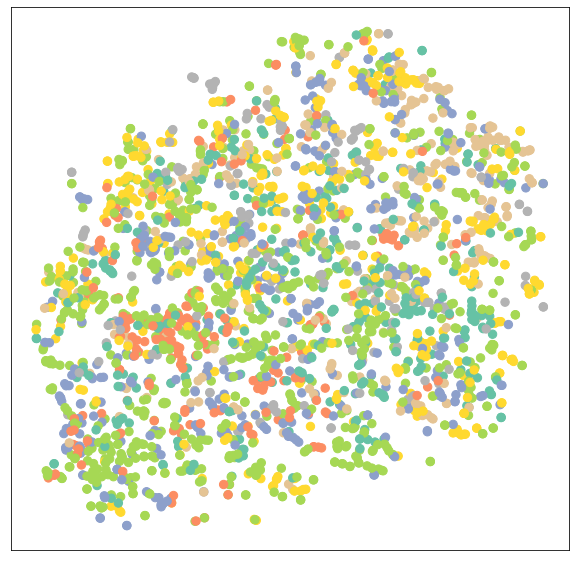

In [29]:
GNNExplainer_model_GCN = GCN(hidden_channels=16)
GNNExplainer_model_GCN.eval()

out = GNNExplainer_model_GCN(dataset_GNNE.x, dataset_GNNE.edge_index)
visualize(out, color=dataset_GNNE.y)


In [30]:
GNNExplainer_optimizer = torch.optim.Adam(GNNExplainer_model_GCN.parameters(), lr=0.01, weight_decay=5e-4)

In [31]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [32]:
def loading_model(load_index):
  GNNExplainer_model_GCN = GCN(hidden_channels=16)
  GNNExplainer_optimizer = torch.optim.Adam(params = GNNExplainer_model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GNNExplainer_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  GNNExplainer_model_GCN.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GNNExplainer_model_GCN, GNNExplainer_optimizer, epoch

In [33]:
def visualize_losses(gnnexplainer_losses, epoch_history):
  gnnexplainer_losses_list = torch.stack(gnnexplainer_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("SA Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gnnexplainer_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [34]:
def train_step():
  GNNExplainer_model_GCN.train(True)

  GNNExplainer_optimizer.zero_grad()  
  GNNExplainer_out_GCN = GNNExplainer_model_GCN(dataset_GNNE.x, dataset_GNNE.edge_index)  

  GNNExplainer_loss = loss_calculations(GNNExplainer_out_GCN[dataset_GNNE.train_mask], dataset_GNNE.y[dataset_GNNE.train_mask])  
  GNNExplainer_loss.backward(retain_graph=True)

  GNNExplainer_optimizer.step()    


  return GNNExplainer_loss


In [35]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [36]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GNNExplainer_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GNNExplainer_model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GNNExplainer_model_training_loss:.4f}')

    GNNExplainer_training_loss_per_epoch.append(GNNExplainer_model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GNNExplainer_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNNExplainer_model_GCN.state_dict(), 'optimizer_state_dict': GNNExplainer_optimizer.state_dict(), 'loss': GNNExplainer_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, GNNExplainer Model Loss: 1.9469
Epoch: 002, GNNExplainer Model Loss: 1.9370
Epoch: 003, GNNExplainer Model Loss: 1.9280
Epoch: 004, GNNExplainer Model Loss: 1.9167
Epoch: 005, GNNExplainer Model Loss: 1.9060
Epoch: 006, GNNExplainer Model Loss: 1.8944
Epoch: 007, GNNExplainer Model Loss: 1.8830
Epoch: 008, GNNExplainer Model Loss: 1.8713
Epoch: 009, GNNExplainer Model Loss: 1.8587
Epoch: 010, GNNExplainer Model Loss: 1.8477
Epoch: 011, GNNExplainer Model Loss: 1.8330
Epoch: 012, GNNExplainer Model Loss: 1.8273
Epoch: 013, GNNExplainer Model Loss: 1.8128
Epoch: 014, GNNExplainer Model Loss: 1.7996
Epoch: 015, GNNExplainer Model Loss: 1.7877
Epoch: 016, GNNExplainer Model Loss: 1.7817
Epoch: 017, GNNExplainer Model Loss: 1.7743
Epoch: 018, GNNExplainer Model Loss: 1.7684
Epoch: 019, GNNExplainer Model Loss: 1.7556
Epoch: 020, GNNExplainer Model Loss: 1.7411
Epoch: 021, GNNExplainer Model Loss: 1.7391
Epoch: 022, GNNExplainer Model Loss: 1.7344
Epoch: 023, GNNExplainer Model L

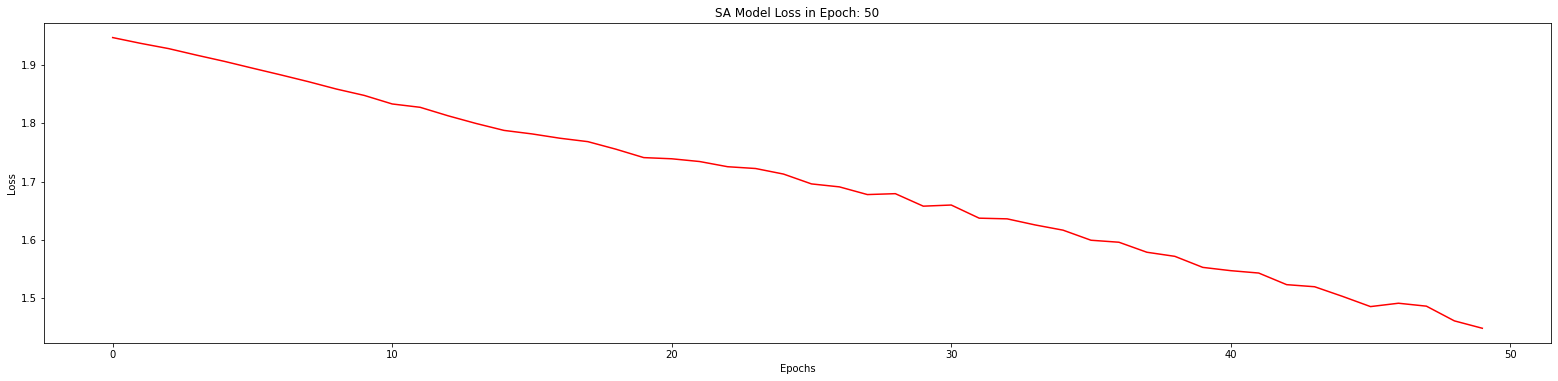

Epoch: 051, GNNExplainer Model Loss: 1.4510
Epoch: 052, GNNExplainer Model Loss: 1.4355
Epoch: 053, GNNExplainer Model Loss: 1.4214
Epoch: 054, GNNExplainer Model Loss: 1.4115
Epoch: 055, GNNExplainer Model Loss: 1.4002
Epoch: 056, GNNExplainer Model Loss: 1.3952
Epoch: 057, GNNExplainer Model Loss: 1.3717
Epoch: 058, GNNExplainer Model Loss: 1.3650
Epoch: 059, GNNExplainer Model Loss: 1.3613
Epoch: 060, GNNExplainer Model Loss: 1.3420
Epoch: 061, GNNExplainer Model Loss: 1.3493
Epoch: 062, GNNExplainer Model Loss: 1.3275
Epoch: 063, GNNExplainer Model Loss: 1.3275
Epoch: 064, GNNExplainer Model Loss: 1.2938
Epoch: 065, GNNExplainer Model Loss: 1.3039
Epoch: 066, GNNExplainer Model Loss: 1.2928
Epoch: 067, GNNExplainer Model Loss: 1.2865
Epoch: 068, GNNExplainer Model Loss: 1.2771
Epoch: 069, GNNExplainer Model Loss: 1.2719
Epoch: 070, GNNExplainer Model Loss: 1.2446
Epoch: 071, GNNExplainer Model Loss: 1.2416
Epoch: 072, GNNExplainer Model Loss: 1.2354
Epoch: 073, GNNExplainer Model L

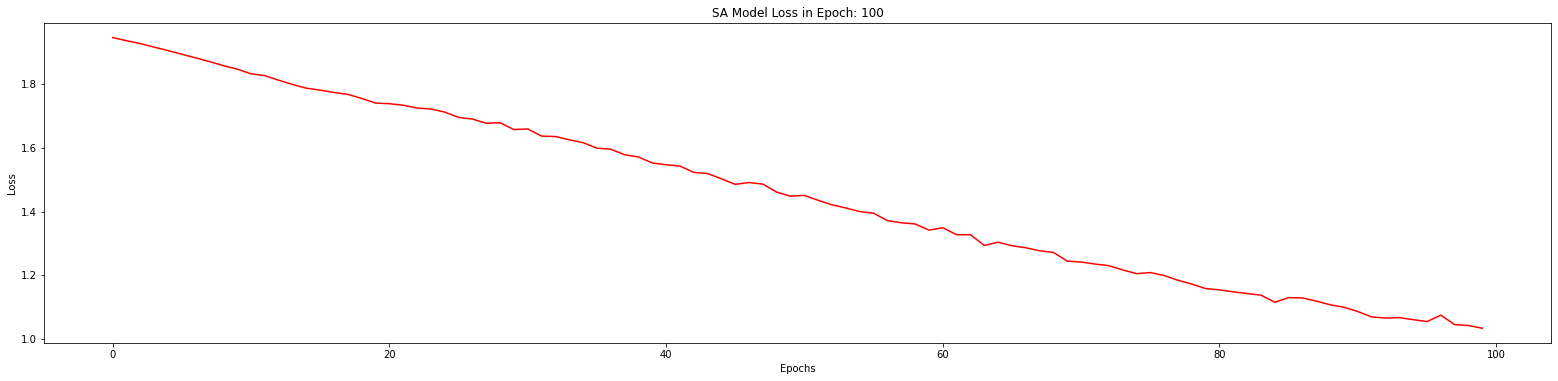

Epoch: 101, GNNExplainer Model Loss: 1.0302
Epoch: 102, GNNExplainer Model Loss: 1.0322
Epoch: 103, GNNExplainer Model Loss: 1.0077
Epoch: 104, GNNExplainer Model Loss: 1.0095
Epoch: 105, GNNExplainer Model Loss: 1.0073
Epoch: 106, GNNExplainer Model Loss: 1.0157
Epoch: 107, GNNExplainer Model Loss: 1.0072
Epoch: 108, GNNExplainer Model Loss: 1.0049
Epoch: 109, GNNExplainer Model Loss: 0.9722
Epoch: 110, GNNExplainer Model Loss: 0.9681
Epoch: 111, GNNExplainer Model Loss: 0.9656
Epoch: 112, GNNExplainer Model Loss: 0.9579
Epoch: 113, GNNExplainer Model Loss: 0.9596
Epoch: 114, GNNExplainer Model Loss: 0.9541
Epoch: 115, GNNExplainer Model Loss: 0.9593
Epoch: 116, GNNExplainer Model Loss: 0.9545
Epoch: 117, GNNExplainer Model Loss: 0.9541
Epoch: 118, GNNExplainer Model Loss: 0.9477
Epoch: 119, GNNExplainer Model Loss: 0.9084
Epoch: 120, GNNExplainer Model Loss: 0.9171
Epoch: 121, GNNExplainer Model Loss: 0.9171
Epoch: 122, GNNExplainer Model Loss: 0.9152
Epoch: 123, GNNExplainer Model L

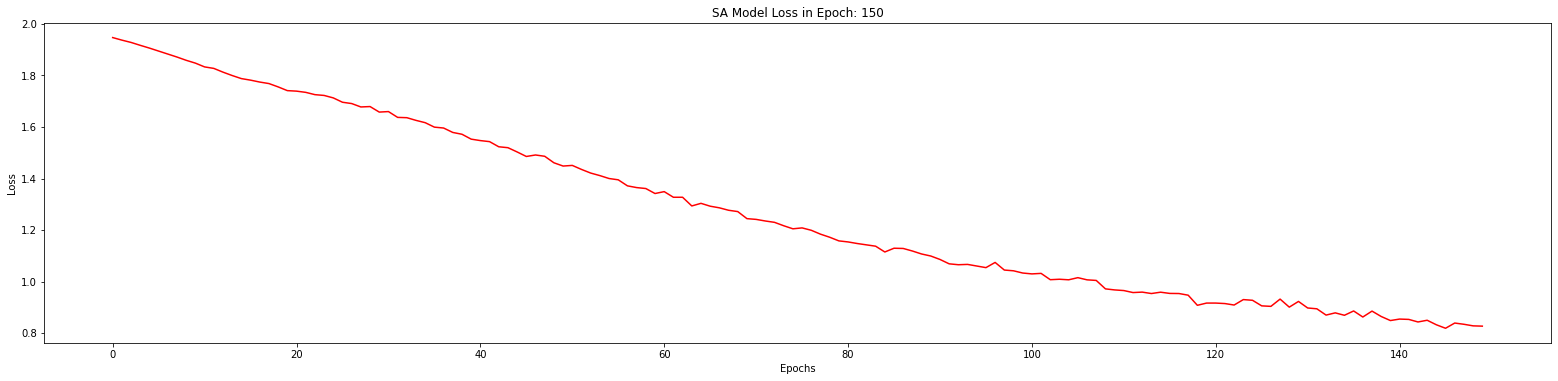

Epoch: 151, GNNExplainer Model Loss: 0.8206
Epoch: 152, GNNExplainer Model Loss: 0.8245
Epoch: 153, GNNExplainer Model Loss: 0.8317
Epoch: 154, GNNExplainer Model Loss: 0.8024
Epoch: 155, GNNExplainer Model Loss: 0.8304
Epoch: 156, GNNExplainer Model Loss: 0.8210
Epoch: 157, GNNExplainer Model Loss: 0.8187
Epoch: 158, GNNExplainer Model Loss: 0.8043
Epoch: 159, GNNExplainer Model Loss: 0.8143
Epoch: 160, GNNExplainer Model Loss: 0.8087
Epoch: 161, GNNExplainer Model Loss: 0.7929
Epoch: 162, GNNExplainer Model Loss: 0.8063
Epoch: 163, GNNExplainer Model Loss: 0.7988
Epoch: 164, GNNExplainer Model Loss: 0.7838
Epoch: 165, GNNExplainer Model Loss: 0.8024
Epoch: 166, GNNExplainer Model Loss: 0.7863
Epoch: 167, GNNExplainer Model Loss: 0.7755
Epoch: 168, GNNExplainer Model Loss: 0.7791
Epoch: 169, GNNExplainer Model Loss: 0.7753
Epoch: 170, GNNExplainer Model Loss: 0.7783
Epoch: 171, GNNExplainer Model Loss: 0.7828
Epoch: 172, GNNExplainer Model Loss: 0.8046
Epoch: 173, GNNExplainer Model L

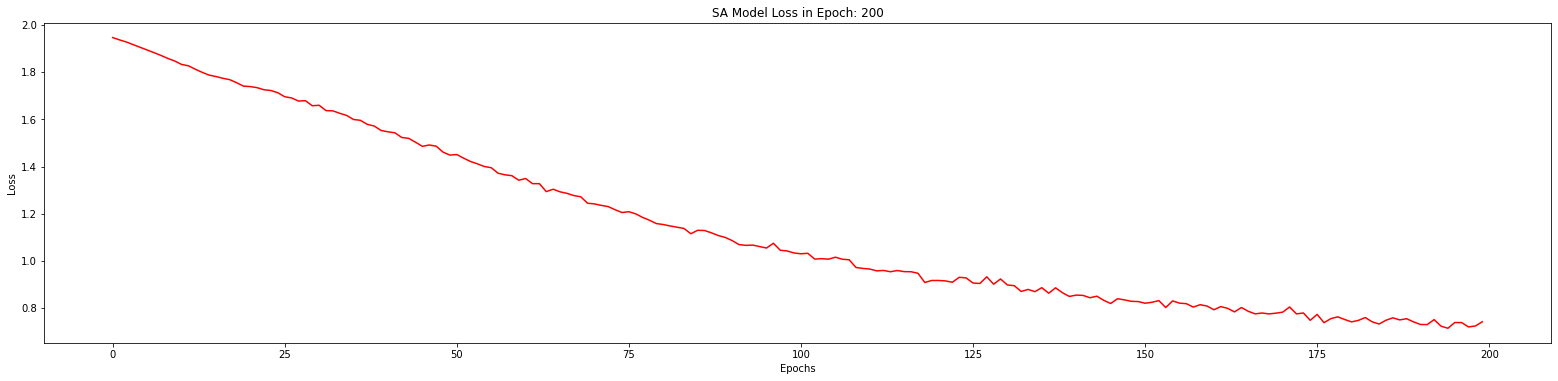

In [37]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [38]:
def GNNExplainer_test():
  GNNExplainer_model_GCN.eval()
  GNNExplainer_out = GNNExplainer_model_GCN(dataset_GNNE.x, dataset_GNNE.edge_index)
  GNNExplainer_pred = GNNExplainer_out.argmax(dim=1) 
  GNNExplainer_test_correct = GNNExplainer_pred[dataset_GNNE.test_mask] == dataset_GNNE.y[dataset_GNNE.test_mask] 
  GNNExplainer_test_acc = int(GNNExplainer_test_correct.sum()) / int(data.test_mask.sum())
  return GNNExplainer_test_acc

In [39]:
GNNExplainer_test_acc = GNNExplainer_test()
print(f'Test Accuracy: {GNNExplainer_test_acc:.4f}')

Test Accuracy: 0.6970


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


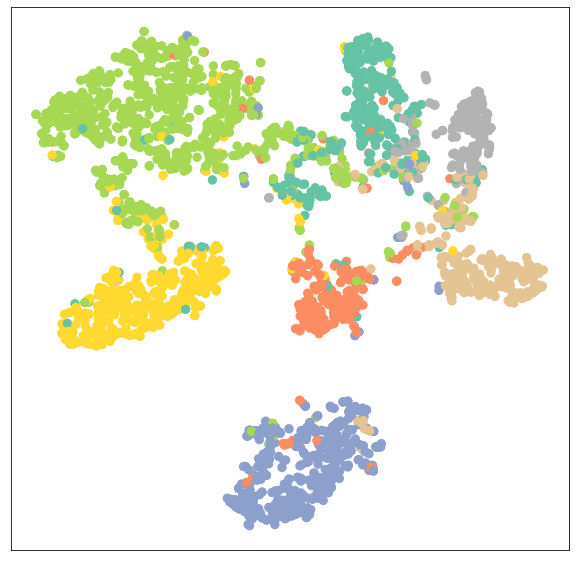

In [40]:
GNNExplainer_model_GCN.eval()

GNNExplainer_test_out = GNNExplainer_model_GCN(dataset_GNNE.x, dataset_GNNE.edge_index)
visualize(GNNExplainer_test_out, color=dataset_GNNE.y)

# **GNNExplainer**


In [41]:
training_node_masks = []
training_edge_masks = []

#node_idx = 10
#x, edge_index = data.x, data.edge_index
gnne_explainer = GNNExplainer(GNNExplainer_model_GCN, epochs=1)
print(len(dataset_GNNE.x[dataset_GNNE.train_mask]))

1891


In [42]:
train_index_list = []
for i in range(len(dataset_GNNE.train_mask)):
  if dataset_GNNE.train_mask[i]:
    train_index_list.append(i)

## **Edge index list for training**

In [43]:
print(len(train_index_list))
training_edge_index_start = []
training_edge_index_end = []

1891


In [44]:
for i in range(len(train_index_list)):
  index = (dataset_GNNE.edge_index[0] == train_index_list[i]).nonzero().view(-1)
  #index = index[torch.randperm(index.size(0))]
  #index = [tensor.item() for tensor in index]
  #print(index)
  for j in index:
    origin = dataset_GNNE.edge_index[0][j].detach().cpu().numpy()
    origin = origin.tolist()
    #index = [tensor.item() for tensor in first]
    training_edge_index_start.append(origin)

    destination = dataset_GNNE.edge_index[1][j].detach().cpu().numpy()
    destination = destination.tolist()
    training_edge_index_end.append(destination)

In [45]:
print(training_edge_index_start)
print(training_edge_index_end)

print(len(training_edge_index_start))
print(len(training_edge_index_end))

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 5, 5, 5, 6, 6, 6, 6, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 18, 18, 18, 18, 18, 21, 21, 22, 22, 22, 22, 22, 23, 25, 25, 25, 25, 26, 26, 26, 26, 26, 28, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 36, 36, 36, 36, 36, 36, 36, 36, 39, 39, 39, 39, 39, 39, 39, 41, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 50, 51, 51, 51, 51, 51, 51, 53, 53, 53, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 57, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61, 61, 61, 62, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 67, 67, 67, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 71, 71, 71, 72, 72, 74, 74, 74, 74, 74, 74, 74, 74, 74, 76, 76, 76, 77, 77, 80, 80, 80, 81, 81, 81, 81, 82, 82, 83, 83, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 8

In [47]:
print(type(dataset_GNNE.edge_index))
print(len(dataset_GNNE.x[dataset_GNNE.train_mask]))

<class 'torch.Tensor'>
1891


# **Masks Generation**

In [48]:
for i in train_index_list:
  node_feat_mask, edge_mask = gnne_explainer.explain_node(i, dataset_GNNE.x, torch.tensor([training_edge_index_start,training_edge_index_end]))
  training_node_masks.append(node_feat_mask)
  training_edge_masks.append(edge_mask)

Explain node 2705: 100%|██████████| 1/1 [00:00<00:00, 209.70it/s]


In [49]:
print("Number of Edges = ",len(training_edge_masks[0]))
print("Number of Nodes = ",len(training_edge_masks))
print(training_edge_masks)

print("Number of Atts = ",len(training_node_masks[0]))
print("Number of Nodes = ",len(training_node_masks))
print(training_node_masks)


Training_Edge_Masks = []
Training_Node_Masks = []

for i in range(len(training_edge_masks)):
  T_E_M = training_edge_masks[i].detach().cpu().numpy()
  Training_Edge_Masks.append(T_E_M.tolist())

  T_N_M = training_node_masks[i].detach().cpu().numpy()
  Training_Node_Masks.append(T_N_M.tolist())

Number of Edges =  7342
Number of Nodes =  1891
[tensor([0.5440, 0.6879, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(

In [50]:
print("Number of Edges = ",len(Training_Edge_Masks[0]))
print("Number of Nodes = ",len(Training_Edge_Masks))

print("Number of Atts = ",len(Training_Node_Masks[0]))
print("Number of Nodes = ",len(Training_Node_Masks))

Number of Edges =  7342
Number of Nodes =  1891
Number of Atts =  1433
Number of Nodes =  1891


In [51]:
print(training_edge_index_start)
print(training_edge_index_end)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 5, 5, 5, 6, 6, 6, 6, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 18, 18, 18, 18, 18, 21, 21, 22, 22, 22, 22, 22, 23, 25, 25, 25, 25, 26, 26, 26, 26, 26, 28, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 36, 36, 36, 36, 36, 36, 36, 36, 39, 39, 39, 39, 39, 39, 39, 41, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 50, 51, 51, 51, 51, 51, 51, 53, 53, 53, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 57, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 61, 61, 61, 61, 61, 62, 63, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 67, 67, 67, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 71, 71, 71, 72, 72, 74, 74, 74, 74, 74, 74, 74, 74, 74, 76, 76, 76, 77, 77, 80, 80, 80, 81, 81, 81, 81, 82, 82, 83, 83, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 8

In [52]:
Training_Node_Masks_copy = Training_Node_Masks.copy()
print(node_feat_mask, edge_mask)
print(len(node_feat_mask))
print(len(edge_mask))
print(data.y)
print(max(data.y))

tensor([0.5523, 0.4998, 0.4925,  ..., 0.5343, 0.5386, 0.5115]) tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4164])
1433
7342
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor(6)


# **GNNExplainer**


In [59]:
Node_Feat_Masks_Class1 = []
Node_Feat_Masks_Class2 = []
Node_Feat_Masks_Class3 = []
Node_Feat_Masks_Class4 = []
Node_Feat_Masks_Class5 = []
Node_Feat_Masks_Class6 = []
Node_Feat_Masks_Class7 = []

In [60]:
for i in range(len(train_index_list)):
  if dataset_GNNE.y[train_index_list[i]] == 0:
    Node_Feat_Masks_Class1.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 1:
    Node_Feat_Masks_Class2.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 2:
    Node_Feat_Masks_Class3.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 3:
    Node_Feat_Masks_Class4.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 4:
    Node_Feat_Masks_Class5.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 5:
    Node_Feat_Masks_Class6.append(Training_Node_Masks[i])
  elif dataset_GNNE.y[train_index_list[i]] == 6:
    Node_Feat_Masks_Class7.append(Training_Node_Masks[i])

In [61]:
print(len(Node_Feat_Masks_Class1), len(Node_Feat_Masks_Class2), len(Node_Feat_Masks_Class3), len(Node_Feat_Masks_Class4), len(Node_Feat_Masks_Class5), len(Node_Feat_Masks_Class6), len(Node_Feat_Masks_Class7))

245 151 292 572 298 208 125


In [66]:
print(len(Node_Feat_Masks_Class1[0]))

1433


In [63]:
Node_Feat_Masks_Class1 = torch.stack(Node_Feat_Masks_Class1).cpu().detach().numpy()
Node_Feat_Masks_Class1 = Node_Feat_Masks_Class1.tolist()
print(Node_Feat_Masks_Class1)

Node_Feat_Masks_Class2 = torch.stack(Node_Feat_Masks_Class2).cpu().detach().numpy()
Node_Feat_Masks_Class2 = Node_Feat_Masks_Class2.tolist()
print(Node_Feat_Masks_Class2)

Node_Feat_Masks_Class3 = torch.stack(Node_Feat_Masks_Class3).cpu().detach().numpy()
Node_Feat_Masks_Class3 = Node_Feat_Masks_Class3.tolist()
print(Node_Feat_Masks_Class3)

Node_Feat_Masks_Class4 = torch.stack(Node_Feat_Masks_Class4).cpu().detach().numpy()
Node_Feat_Masks_Class4 = Node_Feat_Masks_Class4.tolist()
print(Node_Feat_Masks_Class4)

Node_Feat_Masks_Class5 = torch.stack(Node_Feat_Masks_Class5).cpu().detach().numpy()
Node_Feat_Masks_Class5 = Node_Feat_Masks_Class5.tolist()
print(Node_Feat_Masks_Class5)

Node_Feat_Masks_Class6 = torch.stack(Node_Feat_Masks_Class6).cpu().detach().numpy()
Node_Feat_Masks_Class6 = Node_Feat_Masks_Class6.tolist()
print(Node_Feat_Masks_Class6)

Node_Feat_Masks_Class7 = torch.stack(Node_Feat_Masks_Class7).cpu().detach().numpy()
Node_Feat_Masks_Class7 = Node_Feat_Masks_Class7.tolist()
print(Node_Feat_Masks_Class7)

TypeError: ignored

# **Average Masks in Class level**

In [67]:
Node_Feat_Masks_Class1_averaged = np.mean(Node_Feat_Masks_Class1, axis=0)
Node_Feat_Masks_Class2_averaged = np.mean(Node_Feat_Masks_Class2, axis=0)
Node_Feat_Masks_Class3_averaged = np.mean(Node_Feat_Masks_Class3, axis=0)
Node_Feat_Masks_Class4_averaged = np.mean(Node_Feat_Masks_Class4, axis=0)
Node_Feat_Masks_Class5_averaged = np.mean(Node_Feat_Masks_Class5, axis=0)
Node_Feat_Masks_Class6_averaged = np.mean(Node_Feat_Masks_Class6, axis=0)
Node_Feat_Masks_Class7_averaged = np.mean(Node_Feat_Masks_Class7, axis=0)

In [68]:
print(Node_Feat_Masks_Class1_averaged, Node_Feat_Masks_Class2_averaged, Node_Feat_Masks_Class3_averaged, Node_Feat_Masks_Class4_averaged, Node_Feat_Masks_Class5_averaged, Node_Feat_Masks_Class6_averaged, Node_Feat_Masks_Class7_averaged)

[0.49514558 0.49765038 0.49994459 ... 0.49834786 0.49789051 0.49537228] [0.50027856 0.49851738 0.49633423 ... 0.49913701 0.49911863 0.50050744] [0.49660922 0.49695452 0.49881046 ... 0.49393252 0.49709783 0.49888448] [0.49745723 0.49542234 0.49933215 ... 0.49938501 0.49774966 0.49708326] [0.49818858 0.49902419 0.49733905 ... 0.49842363 0.49952991 0.49681793] [0.50010143 0.49649218 0.49828846 ... 0.49594027 0.49921465 0.49666042] [0.50215543 0.49624219 0.50187422 ... 0.5011174  0.49780881 0.49492022]


In [70]:
print(len(Node_Feat_Masks_Class1_averaged))

1433


In [76]:
def GNNExplainer_Masks_Node_Features(average_mask_class):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "One" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))
  
  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Two" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax3 = plt.subplot2grid((7, 1), (2, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Three" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax4 = plt.subplot2grid((7, 1), (3, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Four" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax5 = plt.subplot2grid((7, 1), (4, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Five" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax6 = plt.subplot2grid((7, 1), (5, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Six" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax7 = plt.subplot2grid((7, 1), (6, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Node Feature Masks')
  plt.title("Averaged Nodes Feature Mask in Class : " + "Seven" + "GNN Epoch Number = " + str(EPOCHS) + " & Explainer Epoch Number = " + str(1))

  ax1.plot(average_mask_class[0], color='r')
  ax2.plot(average_mask_class[1], color='r')
  ax3.plot(average_mask_class[2], color='r')
  ax4.plot(average_mask_class[3], color='r')
  ax5.plot(average_mask_class[4], color='r')
  ax6.plot(average_mask_class[5], color='r')
  ax7.plot(average_mask_class[6], color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Averaged_Masks_in_each_Class" + ".png")
  plt.show()

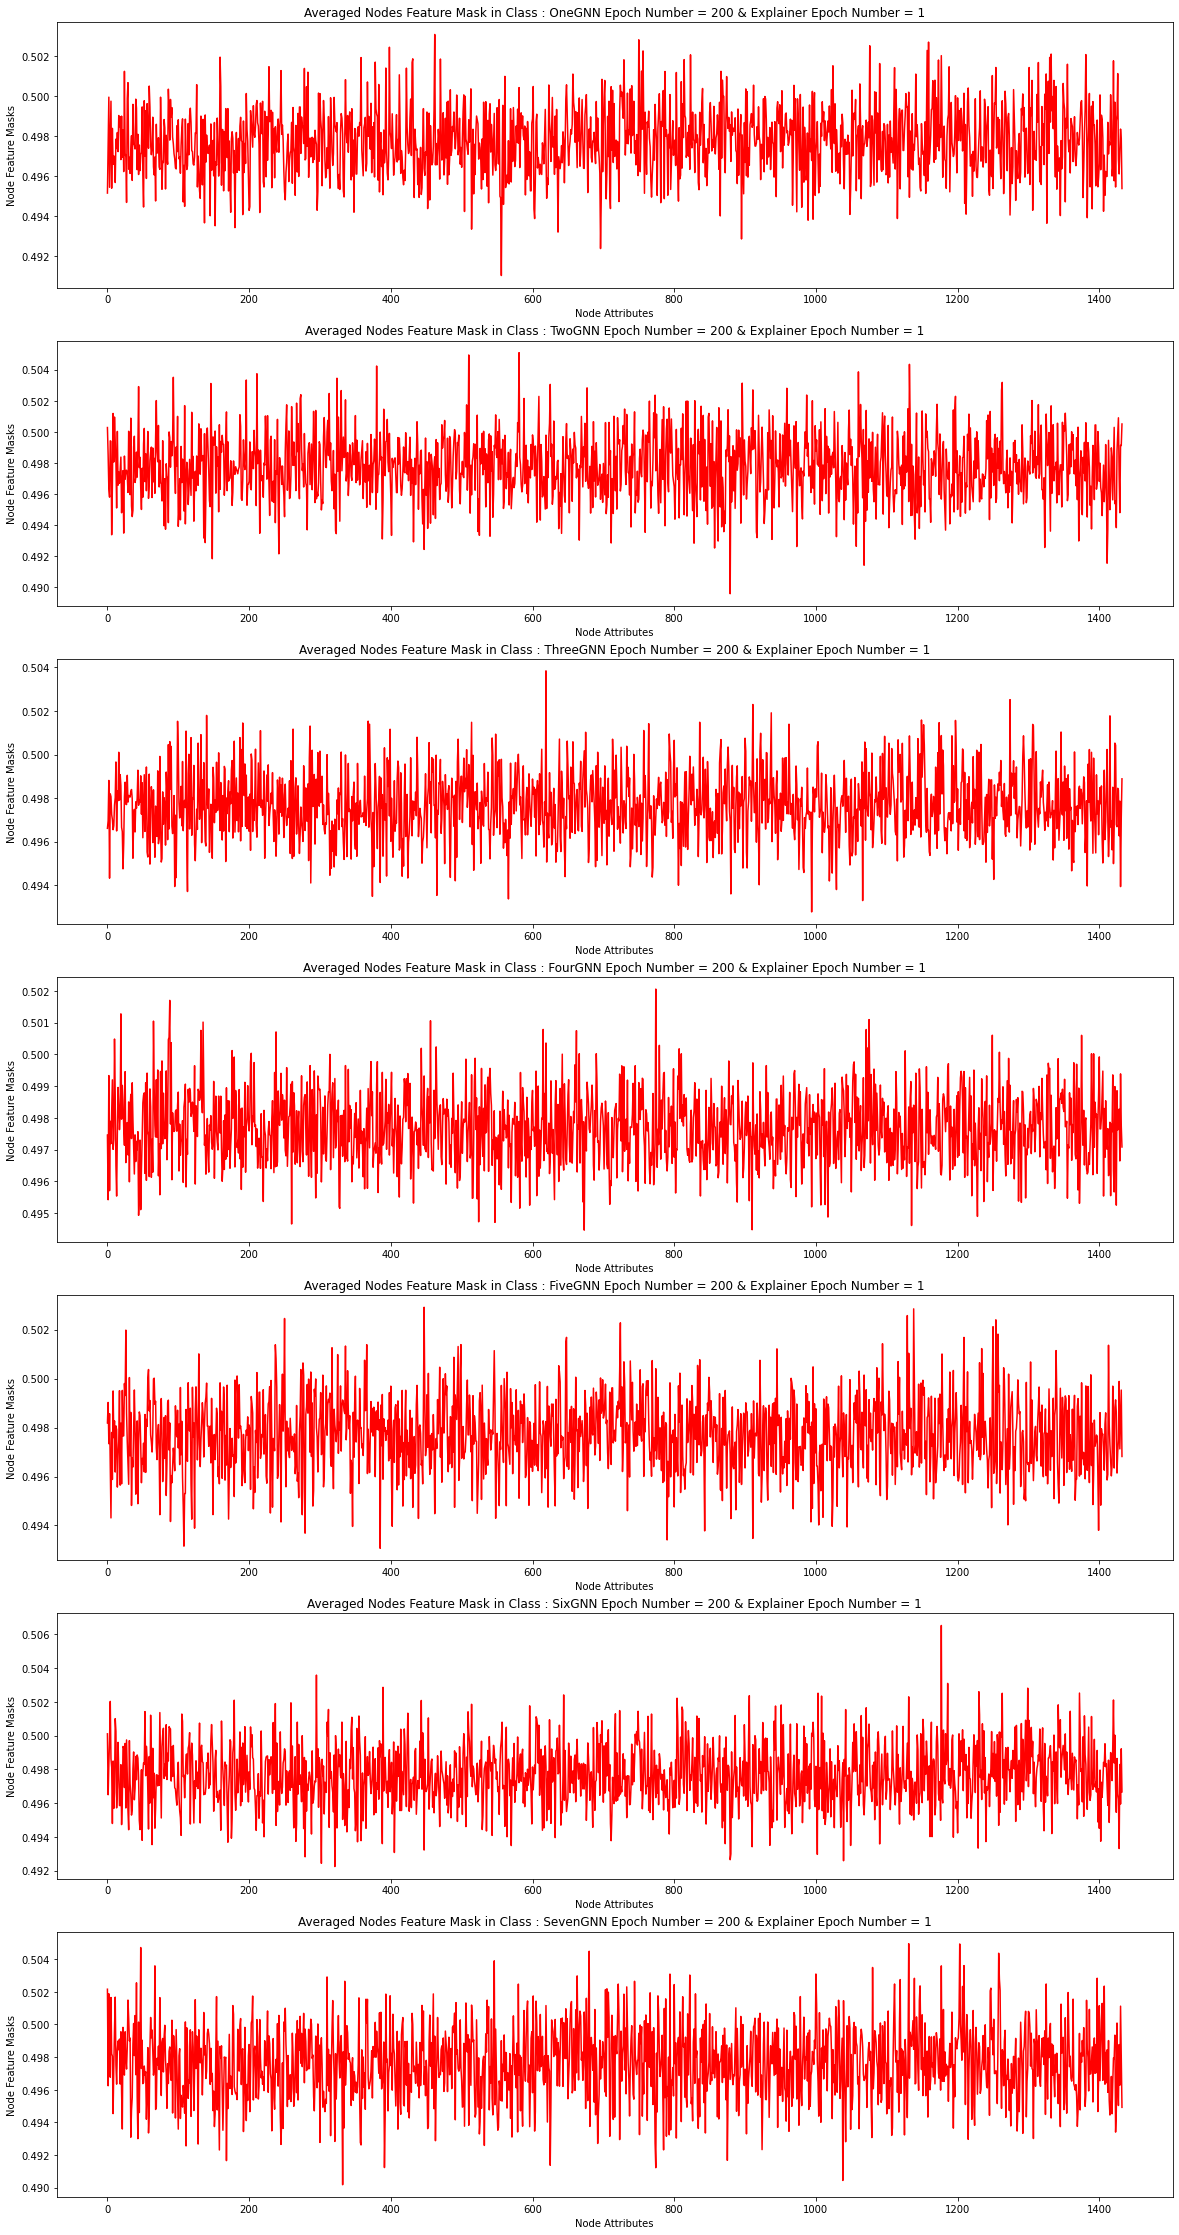

In [77]:
GNNExplainer_Masks_Node_Features([Node_Feat_Masks_Class1_averaged, Node_Feat_Masks_Class2_averaged, Node_Feat_Masks_Class3_averaged, Node_Feat_Masks_Class4_averaged, Node_Feat_Masks_Class5_averaged, Node_Feat_Masks_Class6_averaged, Node_Feat_Masks_Class7_averaged])

In [94]:
def GNNExplainer_Edge_Masks(edge_mask, index, start_node_list, end_node_list, epoch):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Edges")
  plt.ylabel('Edge Masks Masks')
  plt.title("GNNExplainer Edge Mask after training on node " + str(index) + " where the Explainer is trained on " + str(epoch) + " Epoch")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Edges")
  plt.ylabel('Starting node of the edge')
  plt.title("Relation between Edge Mask and Start&End Nodes, Explainer is trained on Node " + str(index) + " where the Explainer is trained on " + str(epoch) + " Epoch")


  ax3 = plt.subplot2grid((7, 1), (2, 0), colspan=7)
  plt.xlabel("Edges")
  plt.ylabel('End node of the edge')
  plt.title("Relation between Edge Mask and Start&End Nodes, Explainer is trained on Node " + str(index) + " where the Explainer is trained on " + str(epoch) + " Epoch")


  ax1.plot(edge_mask, color='r')
  ax2.plot(start_node_list, color='r')
  ax3.plot(end_node_list, color='r')


  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Relation between Edge Mask and Start&End Nodes, Explainer is trained on Node " + str(index) + " for " + str(epoch) + "Epochs.png")
  plt.show()

In [95]:
def start_and_end_nodes(num, epoch):
  start_node_index = (dataset_GNNE.edge_index[0] == num).nonzero().view(-1)
  end_node_index = (dataset_GNNE.edge_index[1] == num).nonzero().view(-1)

  start_node_list = [0] * len(dataset_GNNE.edge_index[0])
  end_node_list = [0] * len(dataset_GNNE.edge_index[0])

  for idx in start_node_index:
    start_node_list[idx] = 1

  for idx in end_node_list:
    end_node_list[idx] = 1
  
  GNNExplainer_Edge_Masks(Training_Edge_Masks[num], num, start_node_list, end_node_list, epoch)

In [92]:
print(train_index_list)

[0, 1, 2, 5, 6, 13, 14, 15, 16, 18, 21, 22, 23, 25, 26, 28, 30, 32, 33, 34, 36, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 71, 72, 74, 76, 77, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 98, 99, 101, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 125, 126, 127, 129, 132, 134, 135, 137, 138, 140, 141, 142, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 158, 159, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 174, 176, 180, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 196, 197, 199, 200, 201, 202, 203, 207, 208, 209, 210, 212, 213, 214, 216, 217, 219, 220, 221, 222, 229, 230, 231, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 249, 251, 252, 253, 254, 255, 257, 258, 260, 261, 262, 263, 264, 265, 266, 269, 270, 271, 273, 276, 277, 278, 280, 281, 283, 284, 285, 287, 289, 291, 293, 294, 295, 297, 298, 299, 302, 303, 305, 308, 309, 311, 312, 314, 315, 317, 32

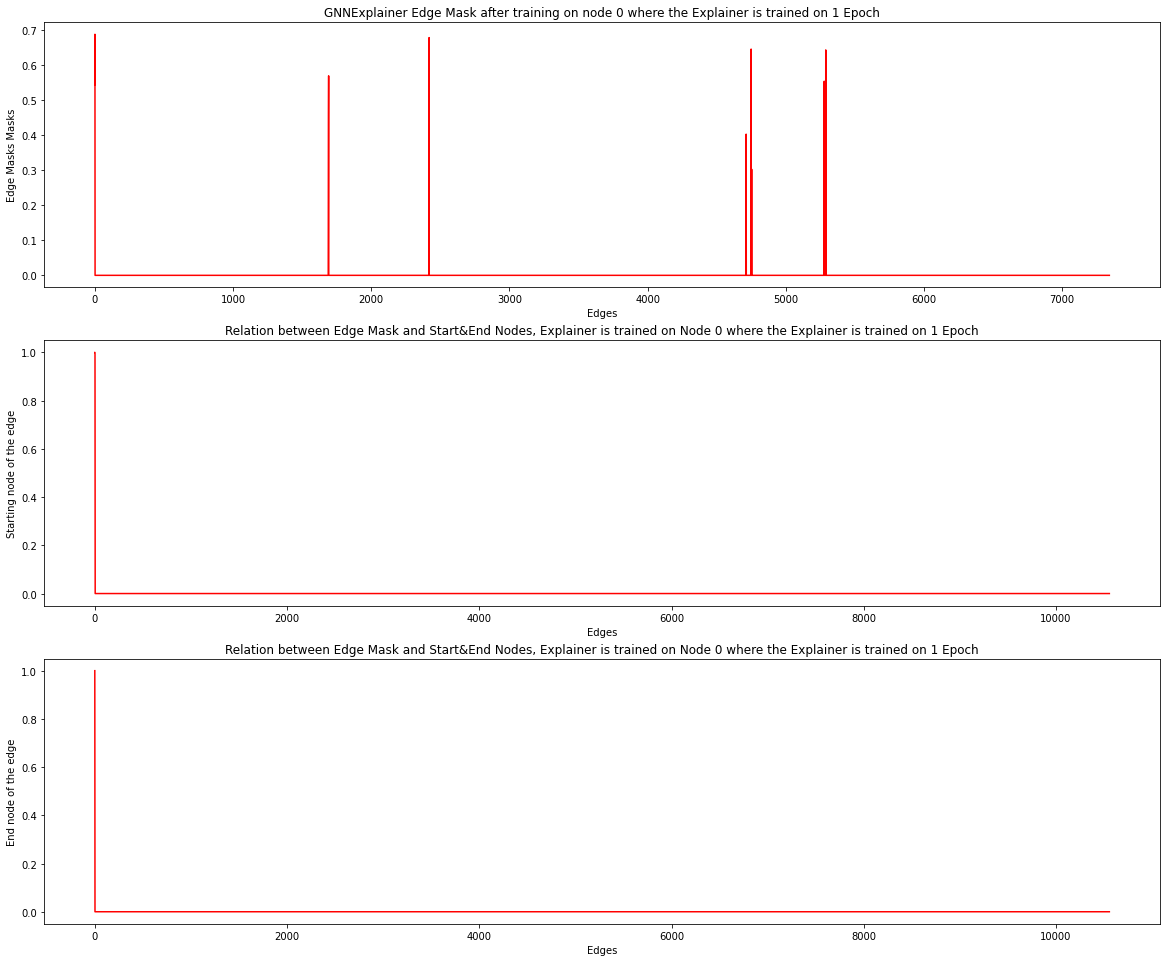

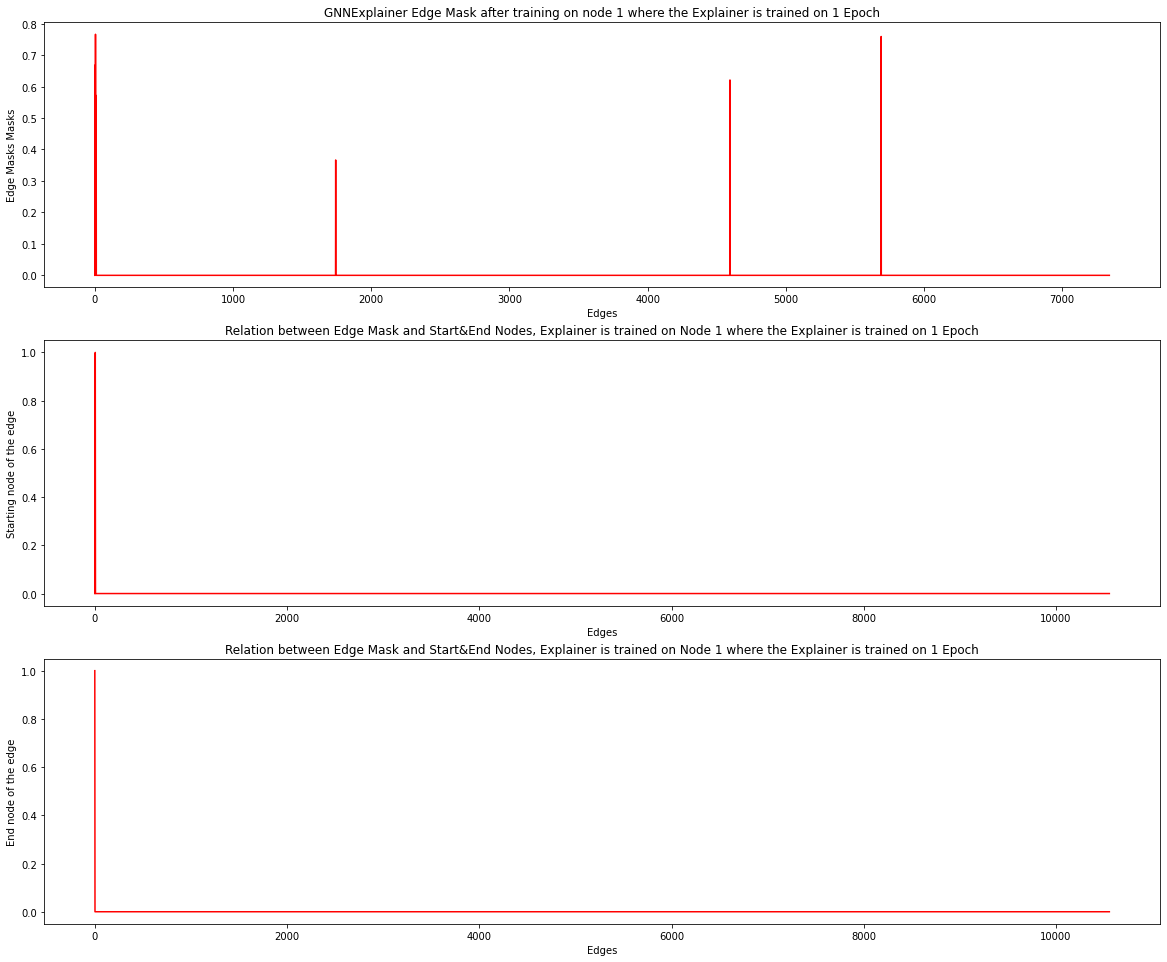

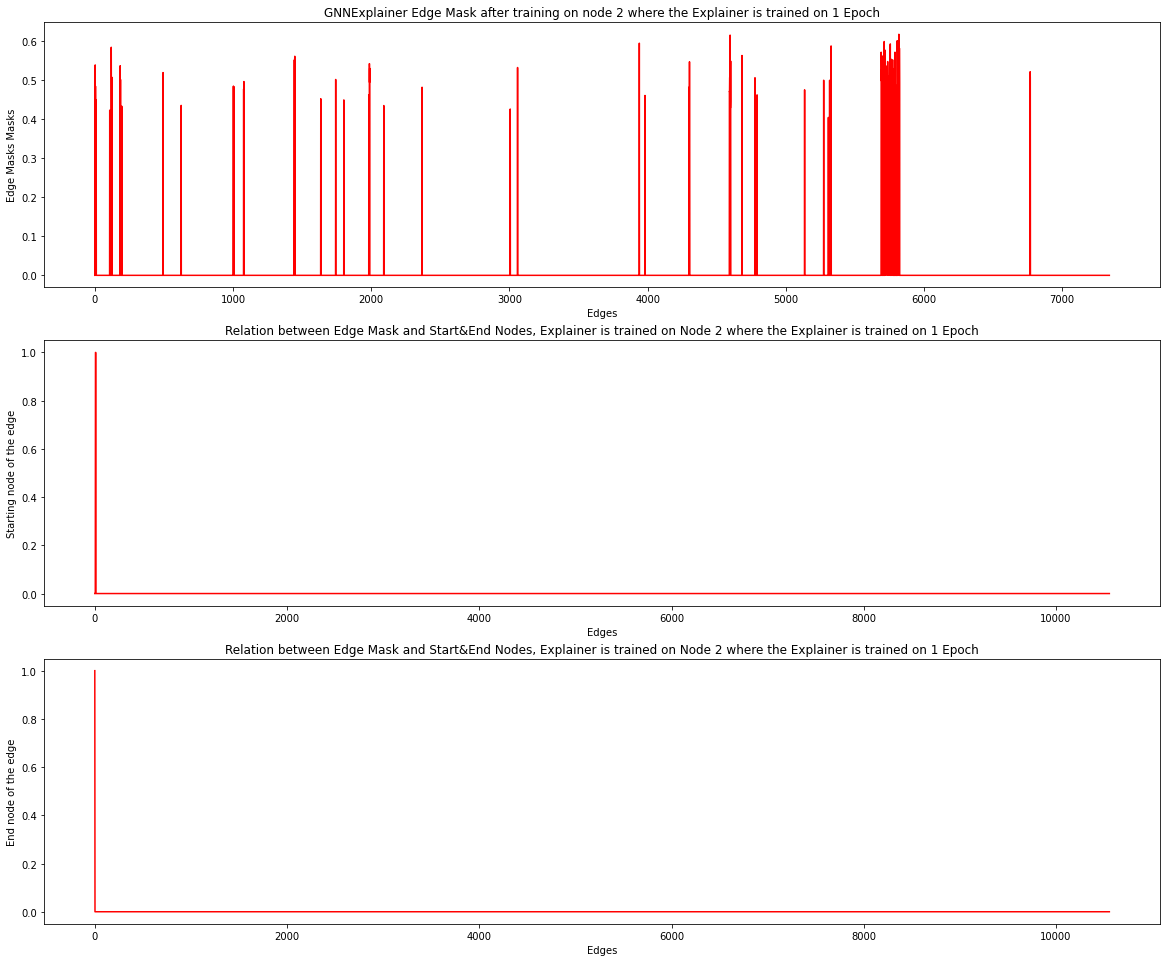

In [96]:
num = [0,1,2]

for i in num:
  start_and_end_nodes(i, 1)

